# Capstone Project 1 - Credit Card Fraud Detection

### Introduction
This is a capstone project of Springboard Data Science Track Bootcamp. The data is from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/overview) closed competition. Kaggle’s data comes from Vesta’s real-world e-commerce transactions and contains a wide range of features from device type to product features.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [2]:
train_identity = pd.read_csv('data/train_identity.csv')
transaction = pd.read_csv('data/train_transaction.csv')
# mask = list(range(int(len(transaction)*0.75)))
train_transaction = transaction[:int(len(transaction)*0.75)]
test_transaction = transaction[int(len(transaction)*0.75):]

The data is broken into two files identity and transaction, which are joined by TransactionID.

In [3]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

According to the transaction dataframe shown above:
1. TransactionDT: timedelta from a given reference datetime (not an actual timestamp. (TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so the unit is seconds. The maximum value of TransactionDT is 15811131, so the data if from 183 days)
2. TransactionAmt: transaction payment amount in USD
3. ProductCD: product code, the product for each transaction.(The product purchased in this transaction, it can be any kind of products such as a service.)
4. card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
5. addr1: billing region, I think it's the area code, first three number of zip code.
6. addr2: billing country
7. dist: distance. (distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.)
8. P_emaildomain: purchase email domain. (gmail.com, yahoo.com, other)
9. R_emaildomain: recipient email domain. (gmail.com, null, other)
10. C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
11. D1-D15: timedelta, such as days between previous transaction, etc.
12. M1-M9: match, such as names on card and address, etc.
13. Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations. (For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.)

In [4]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

According to the identity dataframe above:
1. Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
2. id_01 to id_20: are collected from Vesta
3. id_21 to id_30: are collected from sourceA
4. id_31 to id_38: are collected from sourceB
5. id_30: different systems such as ios or windows
6. id_31: browsers such as chrome or safari.
7. DeviceType: mobile or desktop.
8. DeviceInfo: device information such as their system, version and so on.

### Exploratory analysis
The goal of this part is trying to find patterns and gain insight among features, and select useful features to perform better models. To first get a sense of the timespan of all these transaction data as well as how the fraud cases happen over time. I looked into feature "TransactionDT", which is defined as timedelta from a given reference datetime. The first TransactionDT is 86400 = 24 * 60 * 60 so I assume this feature is in seconds. So we can convert it back to months and days.

In [5]:
# start date is 2017-12-01
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train_transaction['TransactionDT'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_transaction['TransactionDT'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


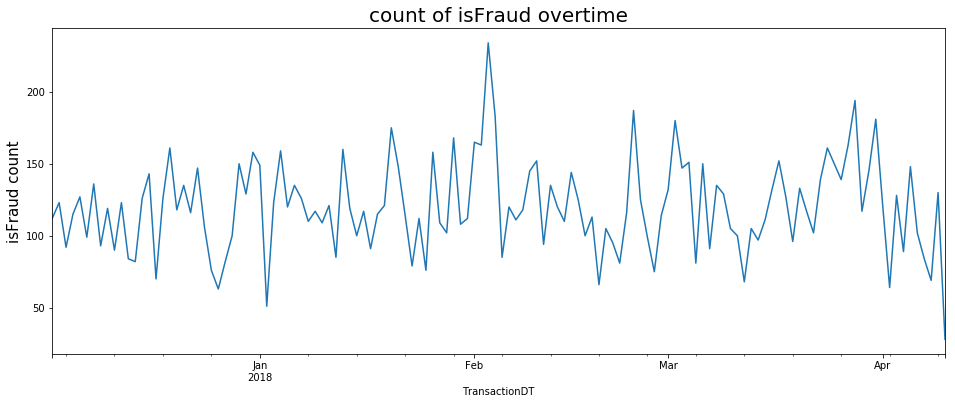

In [6]:
fig = plt.figure(figsize=(16, 6))
count_by_day = train_transaction.set_index('TransactionDT').resample('D').sum()['isFraud']
count_by_day.plot().set_ylabel('isFraud count', fontsize=15)
plt.title('count of isFraud overtime', fontsize=20)
plt.show()

**Observation**: no significant pattern visually based on days.
Now lets isFraud count hourly within a day. We then need a new feature hour.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


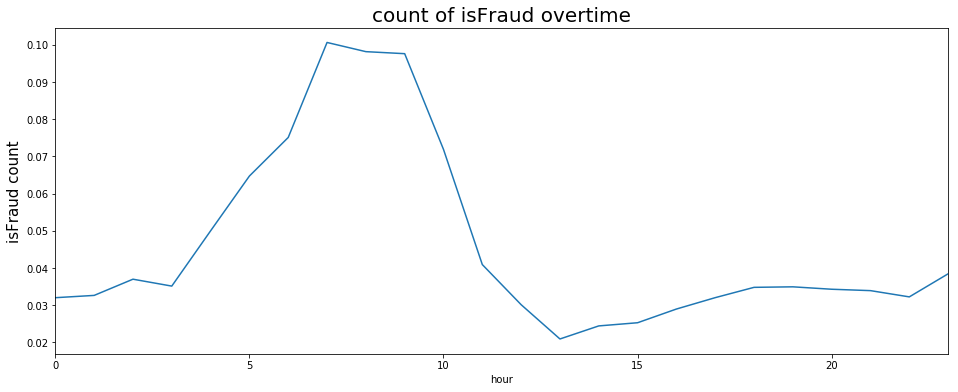

In [7]:
fig = plt.figure(figsize=(16, 6))
train_transaction['hour'] = train_transaction['TransactionDT'].apply(lambda x:x.hour)
count_by_day = train_transaction.groupby('hour').mean()['isFraud']
count_by_day.plot().set_ylabel('isFraud count', fontsize=15)
plt.title('count of isFraud overtime', fontsize=20)
plt.show()

According to the graph above, isFraud counts seems to peak during morning

### Categorical features
- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id_12 - id_38

#### ProductCD

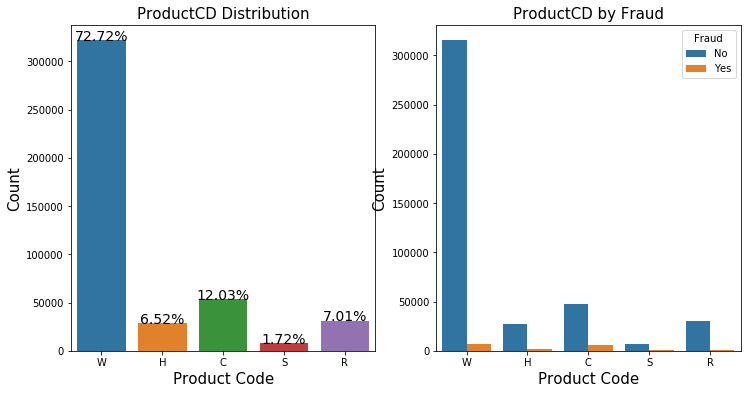

In [8]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_transaction)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

In [9]:
train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.886930
           1          0.113070
H          0          0.954149
           1          0.045851
R          0          0.964043
           1          0.035957
S          0          0.938765
           1          0.061235
W          0          0.979406
           1          0.020594
Name: isFraud, dtype: float64

<Figure size 864x864 with 0 Axes>

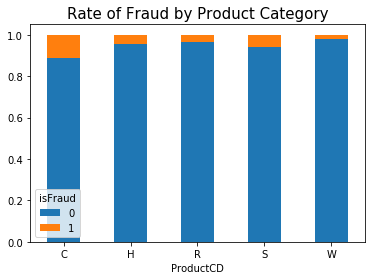

In [10]:
plt.figure(figsize=(12,12))
a = train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Category', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Conclusion**: Product C takes up 67.5% of fraud cases for transactions that have identity. And also have highest rate of fraud: 12%, more than double any other class of product.

**Question**: Why product C? Is there any additional information that help us better understand product C high fraud rate?

We have 2 numerical variables that we can compare between groups of products:

TransactionDT: timedelta from a given reference datetime

TransactionAmt: transaction payment amount in USD

#### P_email_domain

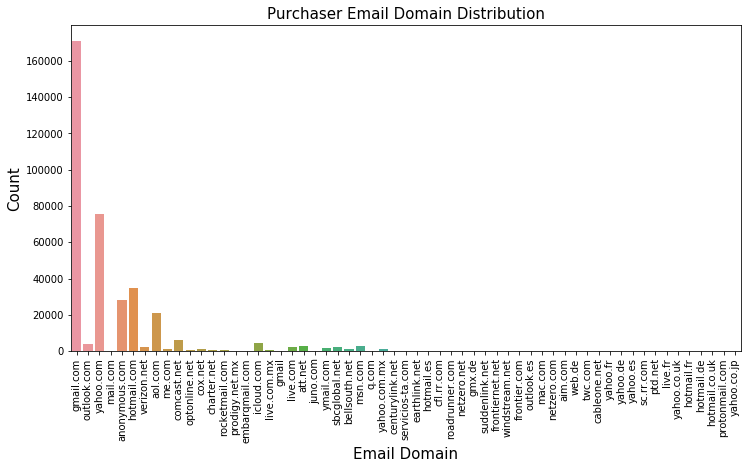

In [11]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_transaction)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**Observation**: we can see a lot of domains came from the same distributors such as hotmail.com, hotmail.fr, yahoo.com, yahoo.fr, yahoo.de, etc. We can group these domains together under the parent distributors.


#### R_emaildomain

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


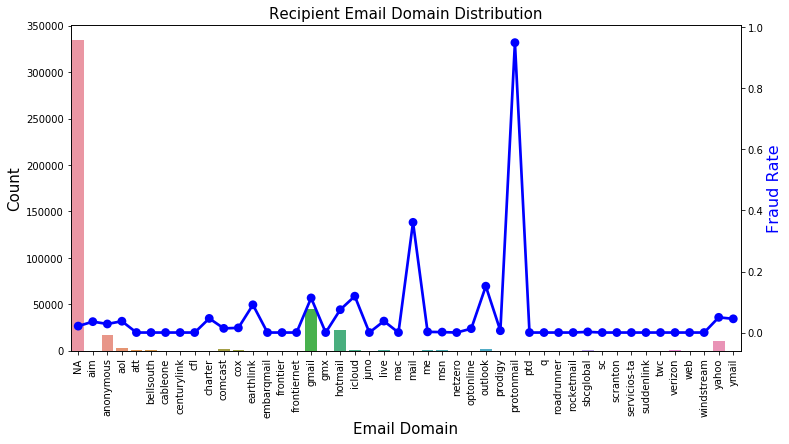

In [12]:
train_transaction["R_parent_emaildomain"] = train_transaction["R_emaildomain"].str.split('.', expand = True)[[0]]
train_transaction["R_parent_emaildomain"].fillna("NA", inplace=True)

R_emaildomain_fraud_rate = train_transaction.groupby('R_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_parent_emaildomain', data = train_transaction, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

#### Card
We are told that card is catagorical data even though card 1, 2, 3, 5 are numerical. lets look at card4 first.

In [13]:
train_transaction.loc[:,'card1':'card5'].head()

card1  card2  card3       card4  card5
0  13926    NaN  150.0    discover  142.0
1   2755  404.0  150.0  mastercard  102.0
2   4663  490.0  150.0        visa  166.0
3  18132  567.0  150.0  mastercard  117.0
4   4497  514.0  150.0  mastercard  102.0

In [14]:
train_transaction.describe().loc[:,'card1':'card5']

card1          card2          card3          card5
count  442905.000000  436143.000000  442082.000000  439850.000000
mean     9862.646240     363.012608     153.330921     199.628894
std      4896.986456     158.133971      11.542589      40.809866
min      1000.000000     100.000000     100.000000     100.000000
25%      6019.000000     210.000000     150.000000     166.000000
50%      9633.000000     361.000000     150.000000     226.000000
75%     14128.000000     512.000000     150.000000     226.000000
max     18396.000000     600.000000     231.000000     237.000000

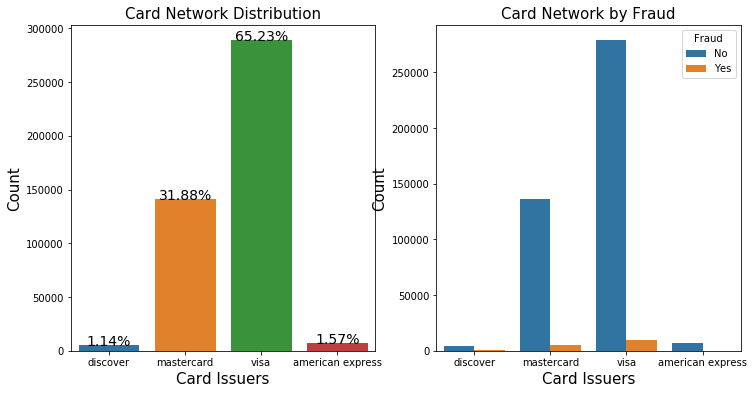

In [15]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_transaction)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

<Figure size 864x864 with 0 Axes>

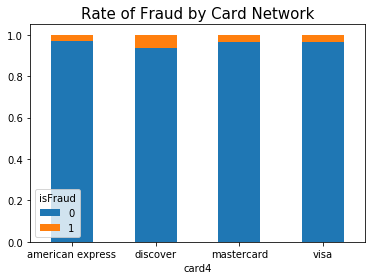

In [16]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_transaction.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Observation**: although visa has the highest counts of isfraud, this is because visa is most used type of card. If we divide it by its population then we can see that american express have a lower fraud rate.

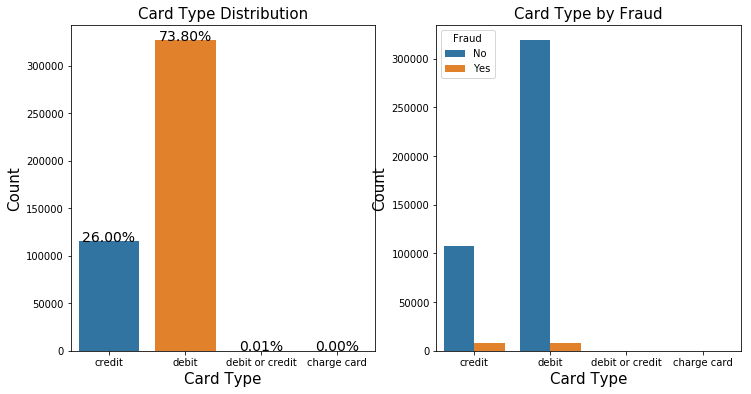

In [17]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_transaction)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_transaction)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

<Figure size 864x864 with 0 Axes>

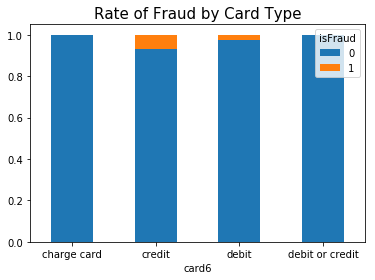

In [18]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_transaction.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Observation**: credit card tend to have a higher fraud rate

####  M1-M9

In [19]:
train_transaction.loc[:, 'M1':'M9'].apply(pd.value_counts)

M1        M2        M3        M4       M5        M6        M7  \
F       20.0   22078.0   45174.0       NaN  97133.0  166633.0  134814.0   
M0       NaN       NaN       NaN  144813.0      NaN       NaN       NaN   
M1       NaN       NaN       NaN   38491.0      NaN       NaN       NaN   
M2       NaN       NaN       NaN   45867.0      NaN       NaN       NaN   
T   213092.0  191034.0  167938.0       NaN  79031.0  141426.0   21062.0   

         M8        M9  
F   98586.0   24166.0  
M0      NaN       NaN  
M1      NaN       NaN  
M2      NaN       NaN  
T   57296.0  131716.0

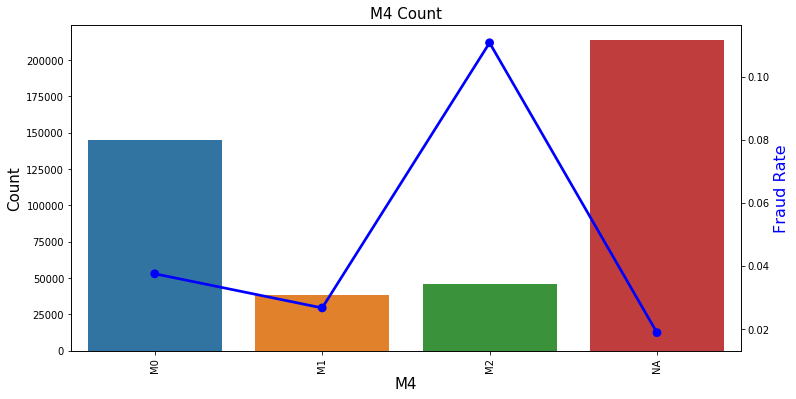

In [20]:
train_transaction['M4'].fillna("NA", inplace=True)
variable_fraud_rate = train_transaction.groupby('M4')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'M4', data = train_transaction, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('M4'), fontsize = 15)
g.set_xlabel("{}".format('M4'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

#### DeviceType

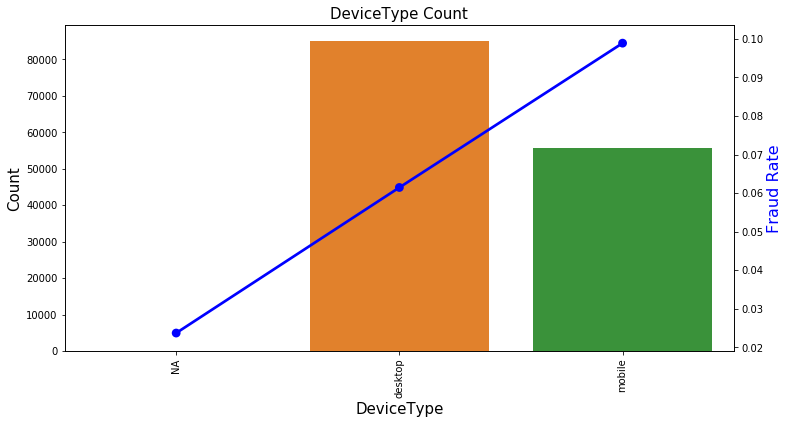

In [21]:
train_full = pd.merge(train_identity, train_transaction, on = 'TransactionID')

train_full['DeviceType'].fillna("NA", inplace=True)
variable_fraud_rate = train_full.groupby('DeviceType')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceType', data = train_identity, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceType'), fontsize = 15)
g.set_xlabel("{}".format('DeviceType'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

**Observation**: mobile device tends to have higher fraud rate.

#### DeviceInfo

In [22]:
train_full['DeviceInfo'].value_counts()

Windows                               38094
iOS Device                            16572
MacOS                                 10506
Trident/7.0                            6221
rv:11.0                                1593
rv:57.0                                 954
SM-J700M Build/MMB29K                   413
SM-G610M Build/MMB29K                   346
SM-G531H Build/LMY48B                   327
SM-G955U Build/NRD90M                   305
SM-G950U Build/NRD90M                   284
SM-G935F Build/NRD90M                   262
rv:58.0                                 259
ALE-L23 Build/HuaweiALE-L23             242
SM-G930V Build/NRD90M                   242
rv:52.0                                 225
SAMSUNG                                 202
SM-N950U Build/NMF26X                   197
SM-G950F Build/NRD90M                   189
SM-A300H Build/LRX22G                   188
hi6210sft Build/MRA58K                  188
SM-G532M Build/MMB29T                   167
rv:48.0                         

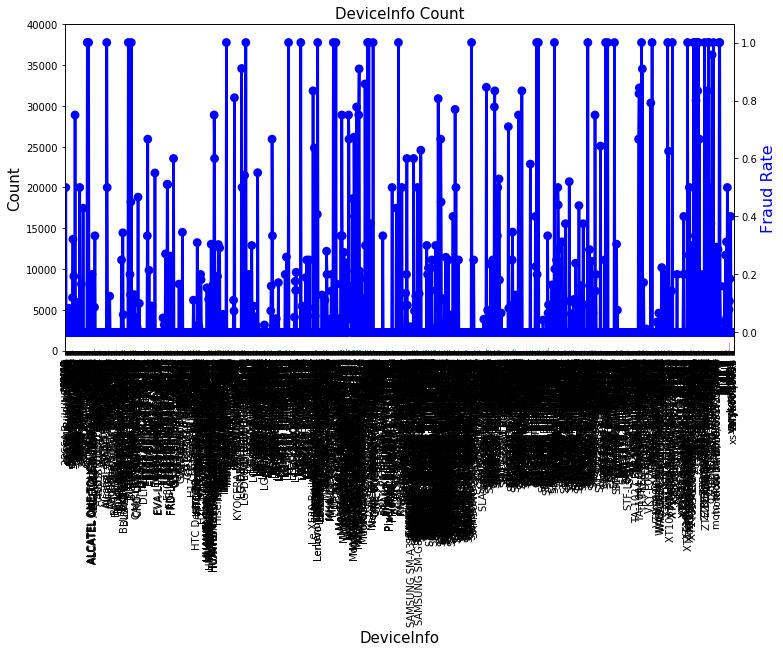

In [23]:
train_full['DeviceInfo'].fillna("NA", inplace=True)
variable_fraud_rate = train_full.groupby('DeviceInfo')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceInfo', data = train_full, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceInfo'), fontsize = 15)
g.set_xlabel("{}".format('DeviceInfo'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

In [24]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()

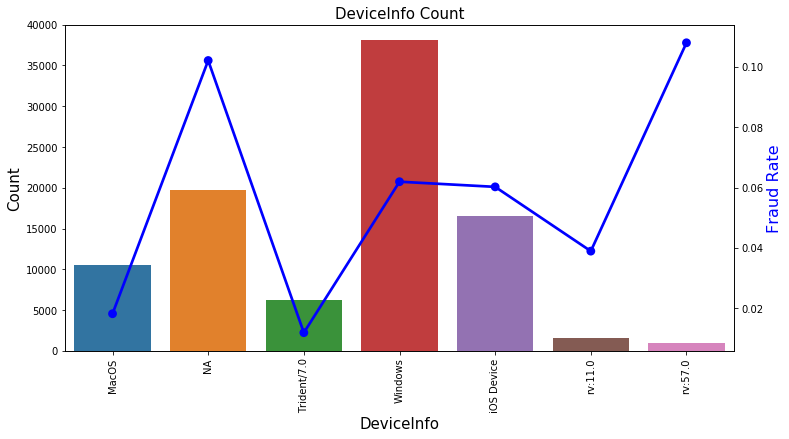

In [25]:
df = train_full[train_full['DeviceInfo'].isin(devicelist)]
df['DeviceInfo'].fillna("NA", inplace=True)
variable_fraud_rate = df.groupby('DeviceInfo')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceInfo', data = df, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceInfo'), fontsize = 15)
g.set_xlabel("{}".format('DeviceInfo'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

**Observation**: MacOS has relatively low fraud rate.

### Numerical Features

#### TransactionAmt

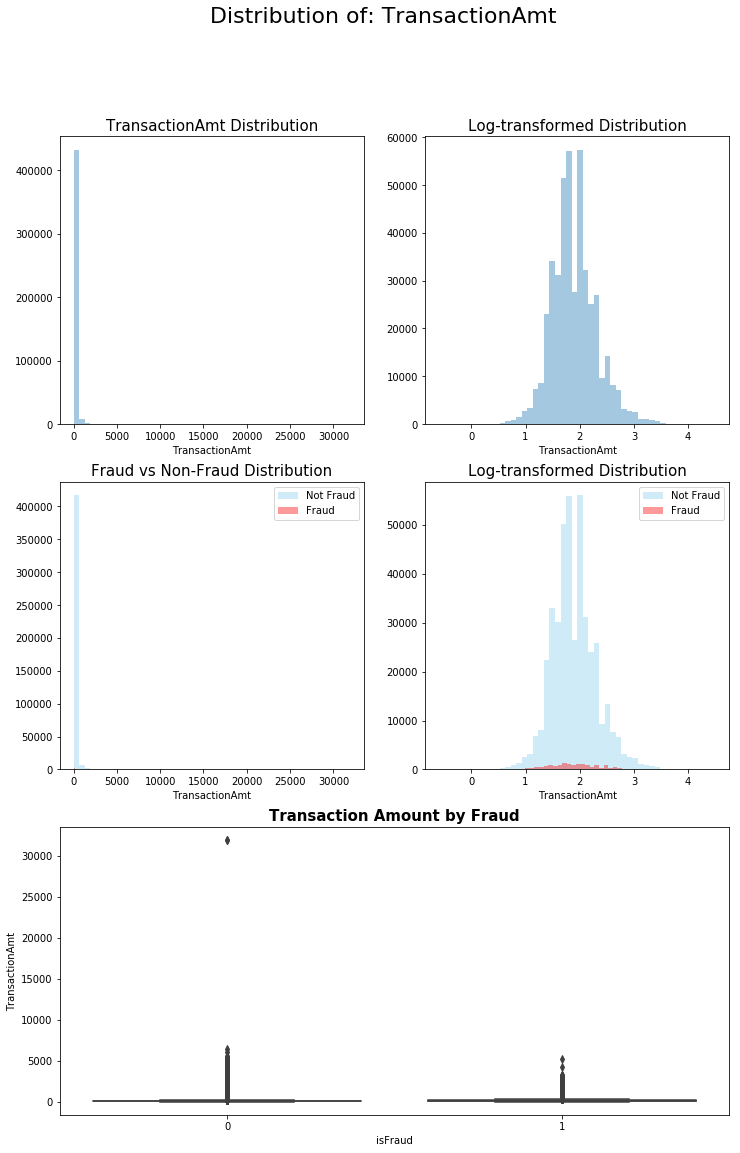

In [26]:
plt.figure(figsize=(12,18))
plt.suptitle('Distribution of: {}'.format('TransactionAmt'), fontsize=22)

plt.subplot(321)
sns.distplot(train_transaction['TransactionAmt'], kde= False)
plt.title('{} Distribution'.format('TransactionAmt'), fontsize = 15)

plt.subplot(322)
sns.distplot(np.log10(train_transaction['TransactionAmt']), kde= False)
plt.title('Log-transformed Distribution', fontsize = 15)


plt.subplot(323)
sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'], color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'], color = 'red', kde= False , label = 'Fraud')
plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
plt.legend()

plt.subplot(324)
sns.distplot(np.log10(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt']), color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(np.log10(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt']), color = 'red', kde= False , label = 'Fraud')
plt.title('Log-transformed Distribution', fontsize = 15)
plt.legend()

plt.subplot(313)
sns.boxplot(x = 'isFraud', y = 'TransactionAmt', data = train_transaction)
plt.title('Transaction Amount by Fraud', fontsize = 15,  weight='bold')
plt.show()

**Observation**: most transactions are small (less than $200)

#### Distance

In [27]:
def visualize_num_variable(variable, df=train_full.copy()):
    if df[variable].isnull().values.any():
        df = train_full.dropna(subset=[variable])

    if df[variable].min() < 0:
        plt.figure(figsize=(12,12))
        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)
    
        plt.subplot(221)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)
        
        plt.subplot(222)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()
        
        plt.subplot(212)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')
        
    else:
        smallest_value = df[df[variable] != 0][variable].min()
        if df[variable].min() == 0:
            df[variable].replace(0, smallest_value/10, inplace=True)       

        plt.figure(figsize=(12,18))
        plt.text(x=0.5, y=0.5,
                 s="Zeros have been replaced with {} to avoid log infinity".format(smallest_value/10),
                 fontsize=12,horizontalalignment='center')

        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

        plt.subplot(321)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)

        plt.subplot(322)
        sns.distplot(np.log10(df[variable]), kde= False)
        plt.title('Log-transformed Distribution', fontsize = 15)


        plt.subplot(323)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(324)
        sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
        plt.title('Log-transformed Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(313)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')
        plt.show()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


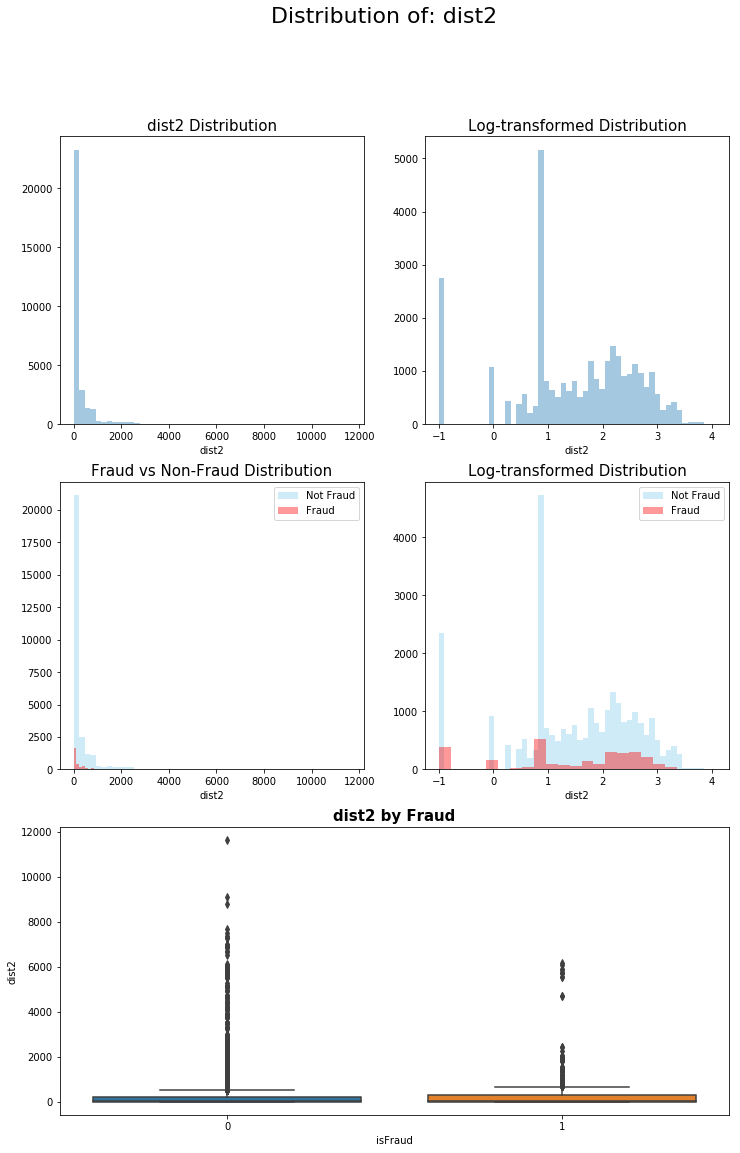

In [28]:
visualize_num_variable('dist2')

#### C
Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

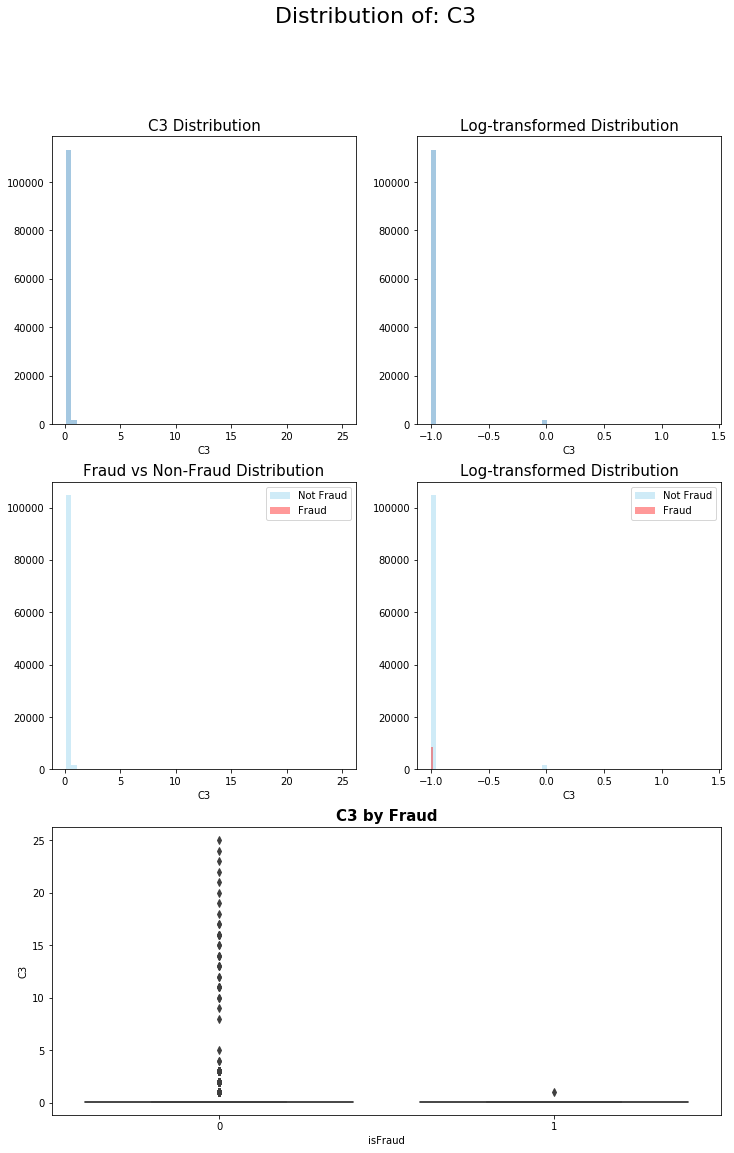

In [29]:
visualize_num_variable('C3')

**Observation**: the higher C3 the lower fraud.
#### D
Timedelta, such as days between previous transaction, etc.

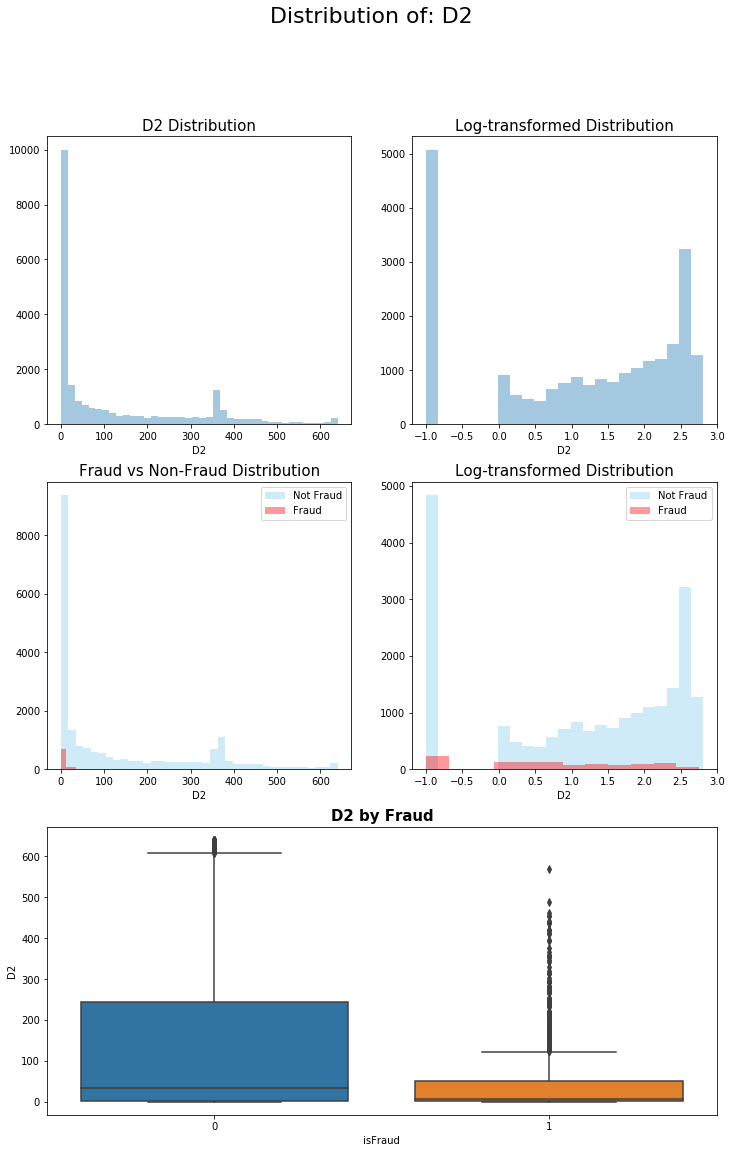

In [30]:
visualize_num_variable('D2')

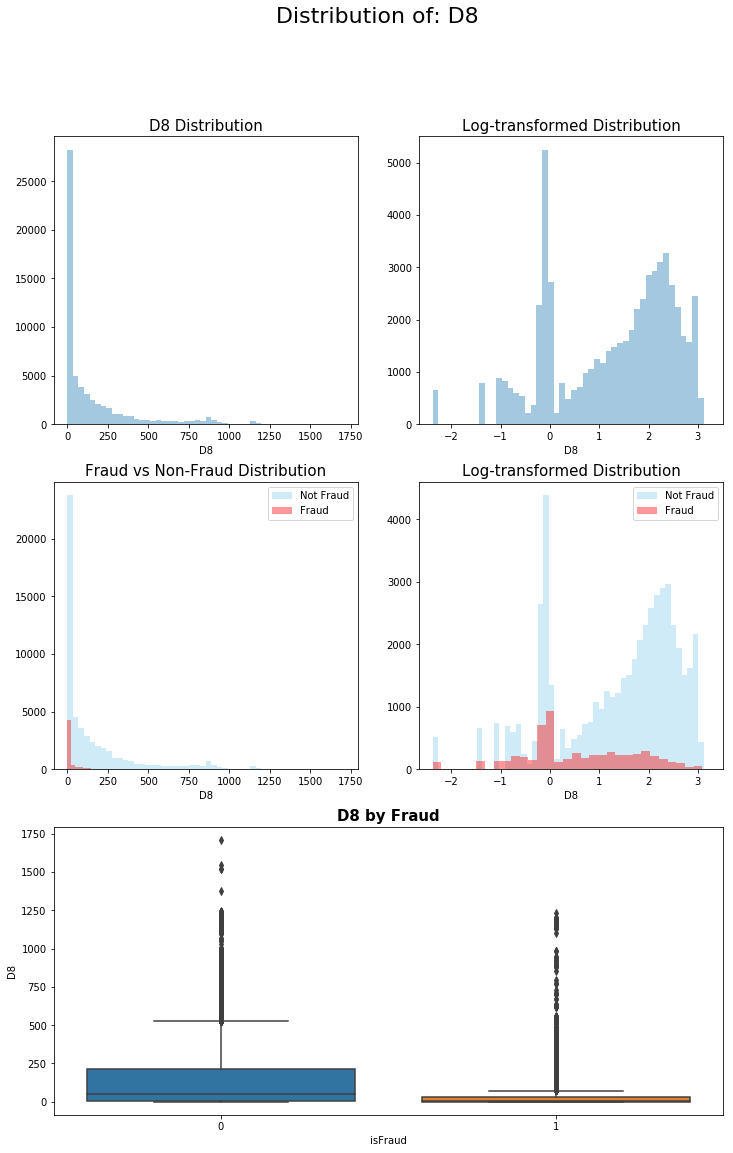

In [31]:
visualize_num_variable('D8')

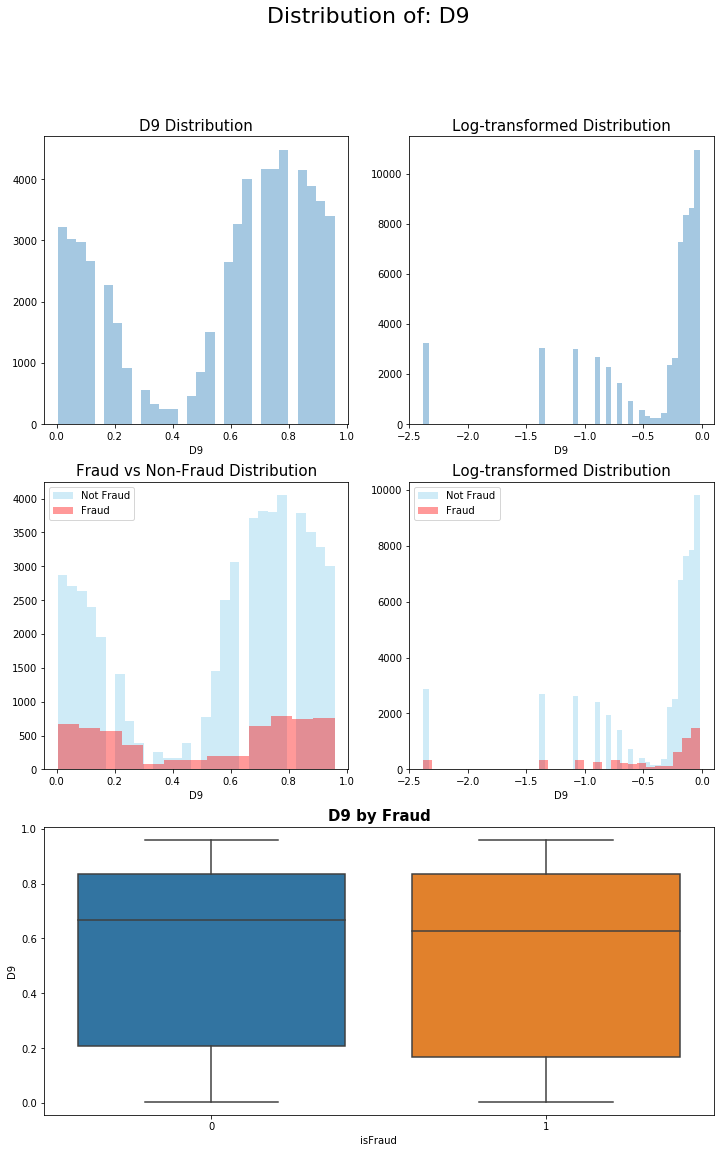

In [32]:
visualize_num_variable('D9')

### Conclusion for EDA:

1. Data has class imbalance problem where fraud counts is much lower than non-fraud counts

2. Multiple columns contain too many missing values

3. Several columns are homogeneous, therefore, prodvide no useful information in predicting the target variable

4. There is period of time during the day where non-fraud far exceed the usual proportion of non-fraud to fraud

5. Basic understand of variables can help us do simple feature engineering



In [34]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
x = transaction['isFraud'].value_counts().index
y = transaction['isFraud'].value_counts().values
trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'peach',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Imbalanced Data -- isFraud",
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

### Models

In [35]:
identity = pd.read_csv('data/train_identity.csv')
transaction = pd.read_csv('data/train_transaction.csv')

In [36]:
transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [37]:
df = transaction.merge(identity, on='TransactionID', how='left')
df.shape

(590540, 434)

In [38]:
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [39]:
cat_cols = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo',
] + [f'M{n}' for n in range(1, 10)] + [f'id_{n}' for n in range(12, 39)]
num_cols = list(set(df.columns) - set(cat_cols))

In [40]:
a = df[num_cols].isnull().any()
df_na_num_cols = a[a].index
nas = {}
for n in df_na_num_cols:
    df[f'{n}_isna'] = df[n].isnull()
    med = df[n].median()
    df[n].fillna(med, inplace=True)
    nas[n] = med

In [41]:
integer_cols = []
for c in num_cols:
    try:
        if df[c].fillna(-1.0).apply(float.is_integer).all():
            integer_cols += [c]
    except Exception as e:
        print("error: ", c, e)

error:  TransactionID descriptor 'is_integer' requires a 'float' object but received a 'int'
error:  isFraud descriptor 'is_integer' requires a 'float' object but received a 'int'
error:  TransactionDT descriptor 'is_integer' requires a 'float' object but received a 'int'


In [42]:
stats = df[integer_cols].describe().transpose()
stats

count        mean         std    min   25%   50%    75%      max
V23    590540.0    1.030310    0.231471    0.0   1.0   1.0    1.0     13.0
V76    590540.0    0.649831    0.517454    0.0   0.0   1.0    1.0      6.0
V115   590540.0    1.032433    0.190335    0.0   1.0   1.0    1.0      6.0
V145   590540.0    3.068680   25.168899    0.0   0.0   0.0    0.0    297.0
dist2  590540.0   49.415459  141.769757    0.0  37.0  37.0   37.0  11623.0
V251   590540.0    0.950725    0.260529    0.0   1.0   1.0    1.0     18.0
D10    590540.0  109.952537  174.319911    0.0   0.0  15.0  150.0    876.0
V292   590540.0    1.239911    3.775012    1.0   1.0   1.0    1.0    323.0
V8     590540.0    1.014602    0.135791    0.0   1.0   1.0    1.0      8.0
D14    590540.0    6.078691   47.650790 -193.0   0.0   0.0    0.0    878.0
V86    590540.0    1.055089    0.387515    0.0   1.0   1.0    1.0     30.0
V14    590540.0    0.999565    0.020857    0.0   1.0   1.0    1.0      1.0
V250   590540.0    0.949373    0.255457    0.0   1.0   1.0    1.0     18.0
V295   590540.0    1.433395   25.962685    0.0   0.0   0.0    0.0    928.0
V198   590540.0    0.990991    0.240462    0.0   1.0   1.0    1.0     21.0
V80    590540.0    0.122219    0.381219    0.0   0.0   0.0    0.0     19.0
V78    590540.0    1.122650    0.721920    0.0   1.0   1.0    1.0     31.0
V71    590540.0    0.122278    0.342980    0.0   0.0   0.0    0.0      6.0
C1     590540.0   14.092458  133.569018    0.0   1.0   1.0    3.0   4685.0
V219   590540.0    0.301952    5.688579    0.0   0.0   0.0    0.0    378.0
V291   590540.0    1.659798   16.252373    1.0   1.0   1.0    1.0   1055.0
V193   590540.0    1.035430    0.836256    0.0   1.0   1.0    1.0     37.0
V288   590540.0    0.183954    0.430610    0.0   0.0   0.0    0.0     10.0
V153   590540.0    0.965753    0.215981    0.0   1.0   1.0    1.0     18.0
V284   590540.0    0.088541    0.338420    0.0   0.0   0.0    0.0     12.0
V88    590540.0    0.999360    0.025292    0.0   1.0   1.0    1.0      1.0
V167   590540.0    0.929119   20.588298    0.0   0.0   0.0    0.0    872.0
V222   590540.0    1.085970    1.434074    0.0   1.0   1.0    1.0    384.0
V225   590540.0    0.042353    0.611830    0.0   0.0   0.0    0.0     51.0
D5     590540.0   25.370124   63.449427    0.0  10.0  10.0   10.0    819.0
...         ...         ...         ...    ...   ...   ...    ...      ...
V178   590540.0    1.572198   33.887187    0.0   0.0   0.0    0.0   1235.0
V4     590540.0    0.919072    0.328544    0.0   1.0   1.0    1.0      6.0
V85    590540.0    0.127172    0.390188    0.0   0.0   0.0    0.0      7.0
V181   590540.0    0.059899    0.616787    0.0   0.0   0.0    0.0     24.0
id_01  590540.0   -6.262839    7.430643 -100.0  -5.0  -5.0   -5.0      0.0
V281   590540.0    0.087594    0.512213    0.0   0.0   0.0    0.0     22.0
V283   590540.0    0.991134    1.557055    0.0   0.0   1.0    1.0     68.0
D7     590540.0    2.744036   27.610524    0.0   0.0   0.0    0.0    843.0
V75    590540.0    0.613086    0.501204    0.0   0.0   1.0    1.0      4.0
V32    590540.0    0.124071    0.347035    0.0   0.0   0.0    0.0     15.0
V55    590540.0    1.058836    0.365635    0.0   1.0   1.0    1.0     17.0
V67    590540.0    0.998366    0.229299    0.0   1.0   1.0    1.0      8.0
V188   590540.0    1.003493    0.326658    0.0   1.0   1.0    1.0     30.0
V93    590540.0    0.131437    0.374820    0.0   0.0   0.0    0.0      7.0
V19    590540.0    0.840026    0.401896    0.0   1.0   1.0    1.0      7.0
V150   590540.0   39.384335  323.490279    1.0   1.0   1.0    1.0   3389.0
V253   590540.0    1.035816    1.699095    0.0   1.0   1.0    1.0    163.0
V89    590540.0    0.000765    0.029435    0.0   0.0   0.0    0.0      2.0
V304   590540.0    0.264202    0.528234    0.0   0.0   0.0    0.0     16.0
V254   590540.0    1.016590    0.638757    0.0   1.0   1.0    1.0     60.0
V232   590540.0    0.222102    4.933589    0.0   0.0   0.0    0.0    337.0
V230   590540.0    1.102808    1.01

In [43]:
int8columns = stats[stats['max'] < 256].index
print(int8columns.shape)
print(int8columns)
int16columns = stats[(stats['max'] >= 256) & (stats['max'] <= 32767)].index
print(int16columns.shape)
print(int16columns)

(239,)
Index(['V23', 'V76', 'V115', 'V251', 'V8', 'V86', 'V14', 'V250', 'V198', 'V80',
       ...
       'V254', 'V230', 'V201', 'V63', 'V109', 'V49', 'V174', 'V139', 'V155',
       'V2'],
      dtype='object', length=239)
(62,)
Index(['V145', 'dist2', 'D10', 'V292', 'D14', 'V295', 'C1', 'V219', 'V291',
       'V167', 'V222', 'D5', 'V280', 'D12', 'D6', 'V294', 'C13', 'D4', 'C2',
       'V322', 'V231', 'V177', 'C10', 'V97', 'V102', 'C11', 'V217', 'C5',
       'V221', 'D13', 'C7', 'dist1', 'D11', 'D3', 'V324', 'D15', 'C8', 'V95',
       'V227', 'C6', 'V233', 'V218', 'C14', 'V96', 'V259', 'V101', 'V245',
       'V293', 'V279', 'D2', 'V168', 'V323', 'C4', 'V103', 'C12', 'D1', 'V179',
       'V143', 'V178', 'D7', 'V150', 'V232'],
      dtype='object')


In [44]:
for c in int8columns:
    df[c] = df[c].astype('int8')
    
for c in int16columns:
    df[c] = df[c].astype('int16')

In [45]:
df.memory_usage().sum()

1064153080

In [46]:
df.head().transpose()

0           1            2           3           4
TransactionID    2987000     2987001      2987002     2987003     2987004
isFraud                0           0            0           0           0
TransactionDT      86400       86401        86469       86499       86506
TransactionAmt      68.5          29           59          50          50
ProductCD              W           W            W           W           H
card1              13926        2755         4663       18132        4497
card2                NaN         404          490         567         514
card3                150         150          150         150         150
card4           discover  mastercard         visa  mastercard  mastercard
card5                142         102          166         117         102
card6             credit      credit        debit       debit      credit
addr1                315         325          330         476         420
addr2                 87          87           87          87          87
dist1                 19           8          287           8           8
dist2                 37          37           37          37          37
P_emaildomain        NaN   gmail.com  outlook.com   yahoo.com   gmail.com
R_emaildomain        NaN         NaN          NaN         NaN         NaN
C1                     1           1            1           2           1
C2                     1           1            1           5           1
C3                     0           0            0           0           0
C4                     0           0            0           0           0
C5                     0           0            0           0           0
C6                     1           1            1           4           1
C7                     0           0            0           0           0
C8                     0           0            0           0           1
C9                     1           0            1           1           0
C10                    0           0            0           0           1
C11                    2           1            1           1           1
C12                    0           0            0           0           0
C13                    1           1            1          25           1
...                  ...         ...          ...         ...         ...
D7_isna             True        True         True        True        True
V212_isna           True        True         True        True       False
V265_isna           True        True         True        True       False
V75_isna           False       False        False       False        True
V32_isna           False       False        False       False        True
V55_isna           False       False        False       False        True
V67_isna           False       False        False       False        True
V188_isna           True        True         True        True       False
V93_isna           False       False        False       False        True
V267_isna           True        True         True        True       False
V19_isna           False       False        False       False        True
V150_isna           True        True         True        True       False
V253_isna           True        True         True        True       False
V89_isna           False       False        False       False        True
V277_isna           True        True         True        True       False
V304_isna          False       False        False       False       False
V254_isna           True        True         True        True       False
V318_isna          False       False        False       False       False
V232_isna           True        True         True        True       False
V230_isna           True        True         True        True       False
V201_isna           True        True         True        True       False
V269_isna           True        True         True        True       False
V63_isna           False   

In [47]:
for c in cat_cols:
    df[c] = df[c].fillna("missing")

In [48]:
cats = {}
for c in cat_cols:
    df[c] = df[c].astype("category")
    df[c].cat.add_categories('unknown', inplace=True)
    cats[c] = df[c].cat.categories

In [49]:
from pandas.api.types import CategoricalDtype
for k, v in cats.items():
    new_dtype = CategoricalDtype(categories=v, ordered=True)
    df[k] = df[k].astype(new_dtype)
for c in cat_cols:
    df[c] = df[c].cat.codes

In [51]:
df['hour'] = df['TransactionDT'].apply(lambda x:x.hour)
X = df.drop('isFraud', axis=1)
y = df['isFraud']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
from sklearn.svm import OneClassSVM
one_svm = OneClassSVM(kernel='linear', gamma='auto')
one_svm.fit(X_train)
y_pre_svm = one_svm.predict(X_test)

In [26]:
y_pre_svm

array([-1,  1, -1, ...,  1, -1,  1])

In [30]:
from sklearn.metrics import f1_score
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
score = f1_score(y_test, y_pre_svm, pos_label=-1)
score

0.6679148245060001

In [45]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
a_score = accuracy_score(y_test, y_pred)

In [46]:
print('Accuracy score is: ' + str(a_score))

Accuracy score is: 0.9690926948216886


In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
roc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC score of Decision Tree is: ' + str(roc_score))

ROC-AUC score of Decision Tree is: 0.7939252778681767


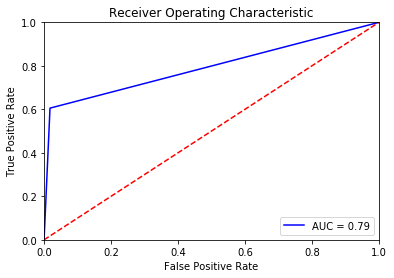

In [48]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
roc_score_rf = roc_auc_score(y_test, y_pred_rf)
print('ROC-ACU score of Random Forest method is: ' + str(roc_score_rf))

ROC-ACU score of Random Forest method is: 0.9351612966354373


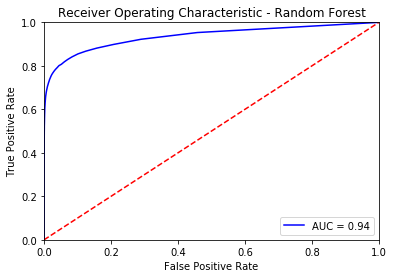

In [51]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
model.fit(X_train, y_train)
y_pred_svc = model.predict(X_test)
roc_score_svc = roc_auc_score(y_test, y_pred_svc)
print('ROC-AUC score of Support Vector Machine is: ' + str(roc_score_svc))

ROC-AUC score of Support Vector Machine is: 0.6499773051620367


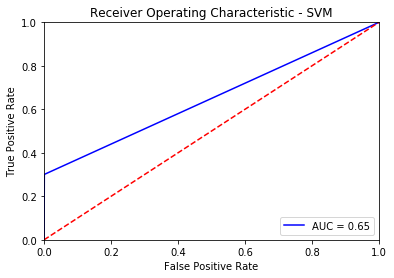

In [54]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusion
I've tried 4 models to predict the fraud action according to the features provided by Kaggle.
1. **One-Class Support Vector Machine**: The accuracy score is 0.668, which is not a good fit of our dataset.
2. **Decision Tree**: Since our data is unblanced dataset, we can't use accuracy score to see our model's performance. Thus I've calculated ROC-AUC score instead. The ROC score of Decision Tree is 0.794, and the roc curve as the graph shown. We can see from the graph that the prediction is not that good.
3. **Random Forest**: the roc score of random forest model is 0.935, which is much higher than the roc score of decision tree. We can also see from the figure that the area under roc curve is larger than decision tree. Thus we know Random Forest is performing better than decision tree.
4. **Support Vector Machine**: the roc socre of support vector machine is only 0.65, which is pretty low. Thus it's probably not a good model to use in this problem.

Therefore, we can conclude that it's better for us to use Random Forest to predict the fraud action at this situation.